In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Flow Matching: Training, Sampling, and Log-Likelihood

## Training Algorithm

### Training Procedure

The Flow Matching (FM) training algorithm follows these steps:

1. Sample time: $t \sim \text{Uniform}(0, 1)$
2. Sample latent variable: $z \sim q(z)$
3. Calculate mean: $\mu_t(z)$
4. Calculate standard deviation: $\sigma_t(z)$
5. Sample interpolated point: $x_t \sim \mathcal{N}(x| \mu(z,t), \sigma(z,t))$
6. Compute vector field: $v(x_t, t; z)$
7. Loss function: 
   $$\mathcal{L}_{\text{CFM}}(\theta) = \|v_\theta(x_t, t) - v(x_t, t; z)\|^2$$
8. Update parameters: $\theta \leftarrow \text{Update}(\theta, \nabla_\theta \mathcal{L}_{\text{CFM}}(\theta))$

## 9.4.2.5 Sampling Procedure

### Sampling from Trained Vector Field Model

1. Initial sampling: $x \sim q_0(x)$
2. Forward Euler method:
   $$x_{t+\Delta} = x_t + v_\theta(x_t, t)\Delta$$
   - Time flows from $t=0$ (noise) to $t=1$ (data)

## Log-Likelihood Calculation

### Approximation using Hutchinson's Trace Estimator

Log-likelihood approximation:
$$\ln p_1(x_1) \approx \ln p_0(x_0) - f_0$$

#### Procedure for Log-Likelihood Estimation

1. Initial conditions:
   $$\begin{bmatrix} \phi_1 \\ f_1 \end{bmatrix} = \begin{bmatrix} x_1 \\ 0 \end{bmatrix}$$

2. ODE for trace estimation:
   $$\frac{d}{ds}\begin{bmatrix} \phi_{1-s} \\ f_{1-s} \end{bmatrix} = \begin{bmatrix} -v_\theta(\phi_{1-s}, 1-s) \\ \epsilon^T \nabla_\phi v_\theta(\phi_{1-s}, 1-s)\epsilon \end{bmatrix}$$
   - $\epsilon \sim \mathcal{N}(0, I)$
   - Use autograd for $\nabla_\phi v_\theta$

3. Solve ODE using backward Euler method from $t=1$ to $t=0$

4. Final approximation:
   $$\ln p_1(x_1) \approx \ln p_0(x_0) - \hat{c}$$

**Note**: This is an approximation with an unbiased estimator. Variance can be reduced by averaging multiple estimations.

## Python Implementation Sketch

```python
def flow_matching_training(model, data):
    # Training procedure implementation
    t = random.uniform(0, 1)
    z = sample_latent_variable()
    mu_t = calculate_mean(z, t)
    sigma_t = calculate_std_dev(z, t)
    x_t = sample_interpolated_point(mu_t, sigma_t)
    vector_field = model(x_t, t)
    loss = calculate_loss(vector_field, true_vector_field)
    update_model_parameters(loss)

def flow_matching_sampling(model, initial_dist):
    # Sampling procedure implementation
    x = initial_dist.sample()
    for t in range(timesteps):
        x += model(x, t) * delta_t
    return x
```

In [2]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist

class VectorFieldNetwork(nn.Module):
    def __init__(self, input_dim=1, hidden_dims=[64, 64]):
        super().__init__()
        layers = []
        prev_dim = input_dim + 1  # Input + time dimension
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU()
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, input_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x, t):
        # Ensure x is 2D and t is expanded correctly
        x = x.view(-1, x.size(-1))
        t_tensor = torch.full((x.size(0), 1), t, device=x.device)
        input_tensor = torch.cat([x, t_tensor], dim=-1)
        return self.network(input_tensor)

class FlowMatching:
    def __init__(self, input_dim=1):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.vector_field_model = VectorFieldNetwork(input_dim).to(self.device)
        self.optimizer = optim.Adam(self.vector_field_model.parameters(), lr=1e-3)
    
    def training_step(self, data_dist, noise_dist):
        # Sample time
        t = torch.rand(1).item()
        
        # Sample from data and noise distributions
        x_data = data_dist.sample().to(self.device)
        x_noise = noise_dist.sample().to(self.device)
        
        # Interpolate between noise and data
        mean_interpolation = t * x_data + (1 - t) * x_noise
        std_interpolation = math.sqrt((1 - t) * 0.1)
        
        # Sample interpolated point
        x_t = mean_interpolation + std_interpolation * torch.randn_like(x_data)
        
        # True vector field (difference between data and noise points)
        true_vector_field = x_data - x_noise
        
        # Predicted vector field
        pred_vector_field = self.vector_field_model(x_t, t)
        
        # Compute loss
        loss = torch.nn.functional.mse_loss(pred_vector_field, true_vector_field)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def sample(self, initial_dist, num_steps=100):
        x = initial_dist.sample().to(self.device)
        
        # Forward Euler sampling
        for t in np.linspace(0, 1, num_steps):
            vector_field = self.vector_field_model(x, t)
            x = x + vector_field * (1/num_steps)
        
        return x
    
    def log_likelihood_estimation(self, x1, initial_dist, num_traces=10):
        def trace_estimator(x1, t):
            # Hutchinson's trace estimator
            epsilon = torch.randn_like(x1)
            x1 = x1.detach().requires_grad_(True)
            
            # Compute vector field
            vector_field = self.vector_field_model(x1, t)
            
            # Compute Jacobian trace
            jac_eps = torch.autograd.grad(
                vector_field, x1, 
                grad_outputs=epsilon, 
                create_graph=True,
                retain_graph=True
            )[0]
            
            return torch.sum(jac_eps * epsilon)
        
        # Solve backward ODE
        def backward_ode(x1):
            x0 = x1
            f0 = 0
            
            for t in np.linspace(1, 0, 100):
                # Backward step
                vector_field = self.vector_field_model(x0, t)
                x0 = x0 - vector_field * 0.01
                f0 += trace_estimator(x0, t) * 0.01
            
            return x0, f0
        
        # Average multiple trace estimations
        x0_estimates = []
        f0_estimates = []
        
        for _ in range(num_traces):
            x0, f0 = backward_ode(x1)
            x0_estimates.append(x0)
            f0_estimates.append(f0)
        
        # Average estimates
        x0_mean = torch.mean(torch.stack(x0_estimates), dim=0)
        f0_mean = torch.mean(torch.stack(f0_estimates))
        
        # Log-likelihood approximation
        log_likelihood = initial_dist.log_prob(x0_mean) - f0_mean
        
        return log_likelihood.item()

def main():
    # Data and initial noise distributions
    data_dist = dist.Normal(torch.tensor([5.0]), torch.tensor([1.0]))
    noise_dist = dist.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
    
    # Initialize Flow Matching
    flow_matcher = FlowMatching()
    
    # Training loop
    for epoch in range(1000):
        loss = flow_matcher.training_step(data_dist, noise_dist)
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")
    
    # Sample from trained model
    sample = flow_matcher.sample(noise_dist)
    print("Generated Sample:", sample)
    
    # Estimate log-likelihood
    log_likelihood = flow_matcher.log_likelihood_estimation(
        data_dist.sample(), 
        noise_dist
    )
    print("Log-Likelihood:", log_likelihood)

if __name__ == '__main__':
    main()

/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch 0, Loss: 38.84886169433594
Epoch 100, Loss: 3.9707624912261963
Epoch 200, Loss: 0.06871027499437332
Epoch 300, Loss: 0.009374180808663368
Epoch 400, Loss: 1.5323888063430786
Epoch 500, Loss: 1.0949550867080688
Epoch 600, Loss: 0.4258871376514435
Epoch 700, Loss: 0.006528803147375584
Epoch 800, Loss: 0.4927144944667816
Epoch 900, Loss: 5.497821807861328
Generated Sample: tensor([[3.7606]], grad_fn=<AddBackward0>)
Log-Likelihood: -6.396724700927734


/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


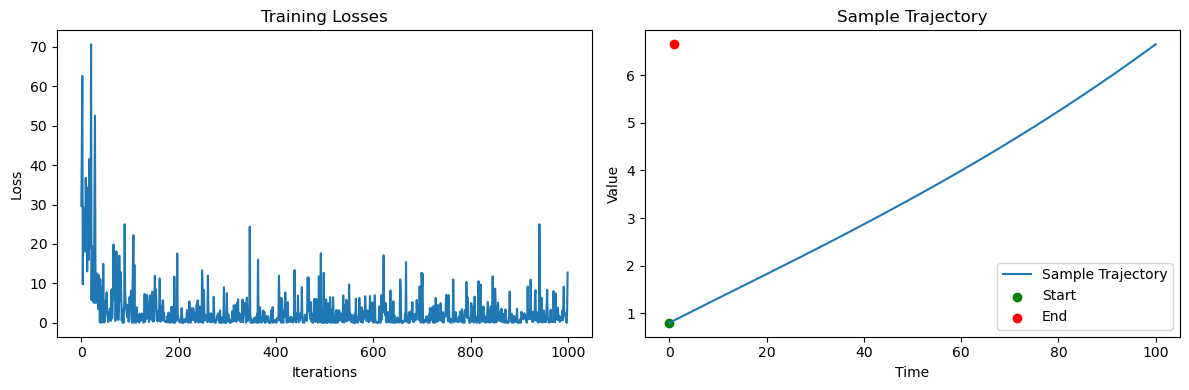

In [4]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
import matplotlib.pyplot as plt

class VectorFieldNetwork(nn.Module):
    def __init__(self, input_dim=1, hidden_dims=[64, 64]):
        super().__init__()
        layers = []
        prev_dim = input_dim + 1  # Input + time dimension
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU()
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, input_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x, t):
        x = x.view(-1, x.size(-1))
        t_tensor = torch.full((x.size(0), 1), t, device=x.device)
        input_tensor = torch.cat([x, t_tensor], dim=-1)
        return self.network(input_tensor)

class FlowMatching:
    def __init__(self, input_dim=1):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.vector_field_model = VectorFieldNetwork(input_dim).to(self.device)
        self.optimizer = optim.Adam(self.vector_field_model.parameters(), lr=1e-3)
        self.losses = []
    
    def training_step(self, data_dist, noise_dist):
        t = torch.rand(1).item()
        
        x_data = data_dist.sample().to(self.device)
        x_noise = noise_dist.sample().to(self.device)
        
        mean_interpolation = t * x_data + (1 - t) * x_noise
        std_interpolation = math.sqrt((1 - t) * 0.1)
        
        x_t = mean_interpolation + std_interpolation * torch.randn_like(x_data)
        
        true_vector_field = x_data - x_noise
        
        pred_vector_field = self.vector_field_model(x_t, t)
        
        loss = torch.nn.functional.mse_loss(pred_vector_field, true_vector_field)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.losses.append(loss.item())
        return loss.item()
    
    def sample(self, initial_dist, num_steps=100):
        x = initial_dist.sample().to(self.device)
        
        samples_trajectory = [x.detach().cpu().numpy()]
        for t in np.linspace(0, 1, num_steps):
            with torch.no_grad():
                vector_field = self.vector_field_model(x, t)
                x = x + vector_field * (1/num_steps)
                samples_trajectory.append(x.detach().cpu().numpy())
        
        return samples_trajectory
    
    def plot_results(self):
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.losses)
        plt.title('Training Losses')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        
        plt.subplot(1, 2, 2)
        noise_dist = dist.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
        data_dist = dist.Normal(torch.tensor([5.0]), torch.tensor([1.0]))
        
        samples = self.sample(noise_dist)
        samples = np.array(samples).squeeze()
        
        plt.plot(samples, label='Sample Trajectory')
        plt.scatter(0, samples[0], color='green', label='Start')
        plt.scatter(1, samples[-1], color='red', label='End')
        plt.title('Sample Trajectory')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

def main():
    data_dist = dist.Normal(torch.tensor([5.0]), torch.tensor([1.0]))
    noise_dist = dist.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
    
    flow_matcher = FlowMatching()
    
    for epoch in range(1000):
        loss = flow_matcher.training_step(data_dist, noise_dist)
    
    flow_matcher.plot_results()

if __name__ == '__main__':
    main()

/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


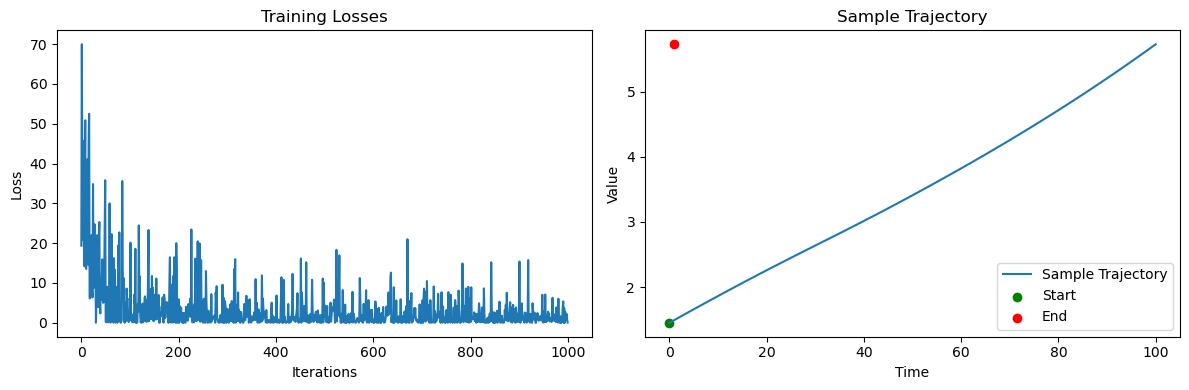

In [5]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
import matplotlib.pyplot as plt

class VectorFieldNetwork(nn.Module):
    def __init__(self, input_dim=1, hidden_dims=[64, 64]):
        super().__init__()
        layers = []
        prev_dim = input_dim + 1  # Input + time dimension
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU()
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, input_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x, t):
        x = x.view(-1, x.size(-1))
        t_tensor = torch.full((x.size(0), 1), t, device=x.device)
        input_tensor = torch.cat([x, t_tensor], dim=-1)
        return self.network(input_tensor)

class FlowMatching:
    def __init__(self, input_dim=1):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.vector_field_model = VectorFieldNetwork(input_dim).to(self.device)
        self.optimizer = optim.Adam(self.vector_field_model.parameters(), lr=1e-3)
        self.losses = []
    
    def training_step(self, data_dist, noise_dist):
        t = torch.rand(1).item()
        
        x_data = data_dist.sample().to(self.device)
        x_noise = noise_dist.sample().to(self.device)
        
        mean_interpolation = t * x_data + (1 - t) * x_noise
        std_interpolation = math.sqrt((1 - t) * 0.1)
        
        x_t = mean_interpolation + std_interpolation * torch.randn_like(x_data)
        
        true_vector_field = x_data - x_noise
        
        pred_vector_field = self.vector_field_model(x_t, t)
        
        loss = torch.nn.functional.mse_loss(pred_vector_field, true_vector_field)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.losses.append(loss.item())
        return loss.item()
    
    def sample(self, initial_dist, num_steps=100):
        x = initial_dist.sample().to(self.device)
        
        samples_trajectory = [x.detach().cpu().numpy()]
        for t in np.linspace(0, 1, num_steps):
            with torch.no_grad():
                vector_field = self.vector_field_model(x, t)
                x = x + vector_field * (1/num_steps)
                samples_trajectory.append(x.detach().cpu().numpy())
        
        return samples_trajectory
    
    def plot_results(self):
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.losses)
        plt.title('Training Losses')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        
        plt.subplot(1, 2, 2)
        noise_dist = dist.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
        data_dist = dist.Normal(torch.tensor([5.0]), torch.tensor([1.0]))
        
        samples = self.sample(noise_dist)
        samples = np.array(samples).squeeze()
        
        plt.plot(samples, label='Sample Trajectory')
        plt.scatter(0, samples[0], color='green', label='Start')
        plt.scatter(1, samples[-1], color='red', label='End')
        plt.title('Sample Trajectory')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

def main():
    data_dist = dist.Normal(torch.tensor([5.0]), torch.tensor([1.0]))
    noise_dist = dist.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
    
    flow_matcher = FlowMatching()
    
    for epoch in range(1000):
        loss = flow_matcher.training_step(data_dist, noise_dist)
    
    flow_matcher.plot_results()

if __name__ == '__main__':
    main()

## Flow Matching Implementation

###  Calculating the Log-Likelihood Function

In this notebook, we implement the Flow Matching technique for generative modeling, focusing on the log-likelihood calculation and conditional flow matching.

## Imports and Setup

```python
import numpy as np
import torch
import torch.nn as nn
```

## Flow Matching Class Implementation

```python
class FlowMatching(nn.Module):
    def __init__(self, vnet, sigma, D, T, stochastic_euler=False, prob_path="icfm"):
        super(FlowMatching, self).__init__()
        
        print('Flow Matching by JT.')
        
        self.vnet = vnet
        self.time_embedding = nn.Sequential(
            nn.Linear(1, D), 
            nn.Tanh()
        )
        
        # Parameters
        self.D = D
        self.T = T
        self.sigma = sigma
        self.stochastic_euler = stochastic_euler
        
        assert prob_path in ["icfm", "fm"], f"Error: The probability path could be either Independent CFM (icfm) or Lipman's Flow Matching (fm) but {prob_path} was provided."
        self.prob_path = prob_path
        
        self.PI = torch.from_numpy(np.asarray(np.pi))
    
    def log_p_base(self, x, reduction='sum', dim=1):
        """Calculate log probability of base distribution (standard Gaussian)"""
        log_p = -0.5 * torch.log(2. * self.PI) - 0.5 * x**2.
        
        if reduction == 'mean':
            return torch.mean(log_p, dim)
        elif reduction == 'sum':
            return torch.sum(log_p, dim)
        else:
            return log_p
    
    def sample_base(self, x_1):
        """Sample from base distribution"""
        if self.prob_path == "icfm":
            return torch.randn_like(x_1)
        elif self.prob_path == "fm":
            return torch.randn_like(x_1)
        else:
            return None
    
    def sample_p_t(self, x_0, x_1, t):
        """Sample from conditional distribution at time t"""
        if self.prob_path == "icfm":
            mu_t = (1. - t) * x_0 + t * x_1
            sigma_t = self.sigma
        elif self.prob_path == "fm":
            mu_t = t * x_1
            sigma_t = t * self.sigma - t + 1.
        
        x = mu_t + sigma_t * torch.randn_like(x_1)
        
        t_embedding = self.time_embedding(torch.Tensor([t]))
        x_t = x_t + self.vnet(x_t + t_embedding) * delta_t
        
        # Stochastic Euler method
        if self.stochastic_euler:
            x_t = x_t + torch.randn_like(x_t) * delta_t
        
        x_final = torch.tanh(x_t)
        return x_final
    
    def log_prob(self, x_1, reduction='mean'):
        """Calculate log probability using backward Euler"""
        ts = torch.linspace(1., 0., self.T)
        delta_t = ts[1] - ts[0]
        
        for t in ts:
            if t == 1.:
                x_t = x_1 * 1.
                f_t = 0.
            else:
                # Calculate phi_t
                t_embedding = self.time_embedding(torch.Tensor([t]))
                x_t = x_t - self.vnet(x_t + t_embedding) * delta_t
                
                # Calculate f_t using Hutchinson trace estimator
                self.vnet.eval()  # Set vector field net to evaluation
                
                x = torch.FloatTensor(x_t.data)  # Copy original data
                x.requires_grad = True
                
                e = torch.randn_like(x)  # epsilon ~ Normal(0, I)
                e_grad = torch.autograd.grad(self.vnet(x).sum(), x, create_graph=True)[0]
                e_grad_e = e_grad * e
                f_t = e_grad_e.view(x.shape[0], -1).sum(dim=1)
                
                self.vnet.train()  # Set vector field net back to training
        
        log_p_1 = self.log_p_base(x_t, reduction='sum') - f_t
        
        if reduction == "mean":
            return log_p_1.mean()
        elif reduction == "sum":
            return log_p_1.sum()
```

## Mathematical Notation

The log-likelihood calculation can be represented mathematically as:

$$
\log p_t(x_t) = \log p_0(x_0) - \int_0^t \text{div}\left(\frac{d\mu_t}{dt} + \sigma_t^2 \nabla \log p_t\right) dt
$$

Where:
- $p_t(x_t)$ is the probability density at time $t$
- $\mu_t$ is the conditional mean
- $\sigma_t$ is the conditional standard deviation
- $\text{div}$ represents the divergence of the vector field

## Two-Moon Dataset Visualization
![image.png](attachment:image.png)


*Fig.9: Generative process on two-moon dataset starting from standard Gaussian distribution*